# Assignment A

1. Design a 3-layer feedforward neural network consisting of a hidden-layer of 10 neurons having logistic activation function and an output softmax layer. Assume a learning rate 𝛼 = 0.01 and decay parameter 𝛽 = 10−6. Use appropriate scaling of input features

In [2]:
import numpy as np
import os
import theano
import theano.tensor as T
import matplotlib.pyplot as plt
import time

Above code is to import all necessary package. The most important package is Theano for making neural network.

In [3]:
# scale data
def scale(X, X_min, X_max):
    return (X - X_min)/(X_max-np.min(X, axis=0))

# load dataset
def load_data(data_path):
    input_txt = np.loadtxt('dataset/sat_train.txt',delimiter=' ')
    X, _Y = input_txt[:,:36], input_txt[:,-1].astype(int)
    X_min, X_max = np.min(X, axis=0), np.max(X, axis=0)
    X = scale(X, X_min, X_max)

    _Y[_Y == 7] = 6
    Y = np.zeros((_Y.shape[0], 6))
    Y[np.arange(_Y.shape[0]), _Y-1] = 1

    return X, Y


These functions are for preprocessing such as loading dataset and scaling. The scale function map the input into range [0,1]

In [4]:
# create bias tensor
def init_bias(n = 1):
    return(theano.shared(np.zeros(n), theano.config.floatX))

# create weights tensor
def init_weights(n_in=1, n_out=1, logistic=True):
    W_values = np.asarray(
        np.random.uniform(
        low=-np.sqrt(6. / (n_in + n_out)),
        high=np.sqrt(6. / (n_in + n_out)),
        size=(n_in, n_out)),
        dtype=theano.config.floatX
        )
    if logistic == True:
        W_values *= 4
    return (theano.shared(value=W_values, name='W', borrow=True))

# update parameters
def sgd(cost, params, lr=0.01):
    grads = T.grad(cost=cost, wrt=params)
    updates = []
    for p, g in zip(params, grads):
        updates.append([p, p - g * lr])
    return updates

These functions is for initializing weight, bias, and stochastic gradient descent(sgd). The weight is initialized by using uniform distribution function. The upper and lower limit of the function is calculated by specific formula to ensure: 
<li>The weights are small and near zero to operate in the linear region of the activation function.</li>
<li>Preserve the variance of activation and feedback gradients</li>
The model use sgd since we train the model with mini-batches.

In [5]:
def create_3_layer_NN(decay, learning_rate, n_input, n_hidden, n_output):
    #debug
    print("Decay: " + str(decay))
    print("Learning rate: " + str(learning_rate))
    print("Input size: %d"%n_input)
    print("Hidden size: %d"%n_hidden)
    print("Output size: %d"%n_output)
    
    # theano expressions
    X = T.matrix() #features
    Y = T.matrix() #output

    w1, b1 = init_weights(n_input, n_hidden), init_bias(n_hidden) #weights and biases from input to hidden layer
    w2, b2 = init_weights(n_hidden, n_output, logistic=False), init_bias(n_output) #weights and biases from hidden to output layer

    # connect layer
    h1 = T.nnet.sigmoid(T.dot(X, w1) + b1)
    py = T.nnet.softmax(T.dot(h1, w2) + b2)

    # decode to category number
    y_x = T.argmax(py, axis=1)

    cost = T.mean(T.nnet.categorical_crossentropy(py, Y)) + decay*(T.sum(T.sqr(w1)+T.sum(T.sqr(w2))))
    params = [w1, b1, w2, b2]
    updates = sgd(cost, params, learning_rate)

    # compile
    train = theano.function(inputs=[X, Y], outputs=cost, updates=updates, allow_input_downcast=True)
    predict = theano.function(inputs=[X], outputs=y_x, allow_input_downcast=True)

    return train, predict


This function create a 3 layer multi perceptron neural network. The layers consist of 1 input layer, 1 hidden layer, and 1 output layer. The hidden layer use sigmoid activation function. The output layer use softmax function instead of sigmoid function since the model need to classify input into more than 2 classes while sigmoid function is only for binary classification. Since output layer use softmax function, the cost of the model is calculated by mean multi-class cross-entropy. 

In [6]:
# suffle data
def shuffle_data (samples, labels):
    idx = np.arange(samples.shape[0])
    np.random.shuffle(idx)
    #print  (samples.shape, labels.shape)
    samples, labels = samples[idx], labels[idx]
    return samples, labels

def run_NN_model(train, predict, batch_size, trainX, trainY, testX, testY, epochs):
    #debug
    print("Batch size: %d"%batch_size)
    # train and test
    n = len(trainX)
    test_accuracy = []
    train_cost = []
    for i in range(epochs):
        if i%100 == 0:
            print("Epoch: %d"%i)
        
        trainX, trainY = shuffle_data(trainX, trainY)
        cost = 0.0
        for start, end in zip(range(0, n, batch_size), range(batch_size, n, batch_size)):
            cost += train(trainX[start:end], trainY[start:end])
        train_cost = np.append(train_cost, cost/(n // batch_size))
        
        test_accuracy = np.append(test_accuracy, np.mean(np.argmax(testY, axis=1) == predict(testX)))

    print('%.1f accuracy at %d iterations'%(np.max(test_accuracy)*100, np.argmax(test_accuracy)+1))

    return train_cost, test_accuracy


These functions above are used to run multi layer perceptron in mini-batch.

In [7]:
def createNewFolder(folder_path):
    #Create folder for saving figure
    if not os.path.isdir(folder_path):
        os.mkdir(folder_path)

def draw_plot(listX, listY, labelX, labelY, title, save_folder_path, file_name):
    createNewFolder(save_folder_path)

    plt.figure()
    plt.plot(listX, listY)
    plt.xlabel(labelX)
    plt.ylabel(labelY)
    plt.title(title)
    plt.savefig(os.path.join(save_folder_path, file_name))
    plt.show()

def draw_multi_plot(listX, dict_listY, labelX, labelY, list_plot_label, prefix_plot_label, title, save_folder_path, file_name):
    createNewFolder(save_folder_path)

    plt.figure()

    for plot_label in list_plot_label:
        plt.plot(listX, dict_listY[plot_label], label=str(prefix_plot_label)+str(plot_label))
    
    plt.legend()
    plt.xlabel(labelX)
    plt.ylabel(labelY)
    plt.title(title)
    plt.savefig(os.path.join(save_folder_path, file_name))
    plt.show()


These code above are for visualization purpose. There are 2 kind of ploting used in this experiment. The first one is one line plot and the second one is multi line plot.

In [8]:
decay = 1e-6
learning_rate = 0.01
n_input = 36
n_hidden = 10
n_output = 6
epochs = 1000
batch_size = 32
dataset_dir_path = "dataset"
train_data_path = os.path.join(dataset_dir_path, "sat_train.txt")
test_data_path = os.path.join(dataset_dir_path, "sat_test.txt")
figure_dir_path = "figure"


All variable above are prepared in case of training model with different data and parameter. The next section is to test the neural network by runnning it. The plot figures and saved inside figure folder.

((4435, 36), (4435, 6))
((4435, 36), (4435, 6))
Decay: 1e-06
Learning rate: 0.01
Input size: 36
Hidden size: 10
Output size: 6
Batch size: 32
Epoch: 0
Epoch: 100
Epoch: 200
Epoch: 300
Epoch: 400
Epoch: 500
Epoch: 600
Epoch: 700
Epoch: 800
Epoch: 900
85.1 accuracy at 977 iterations


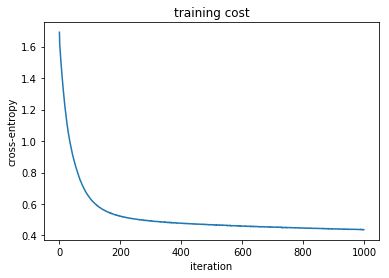

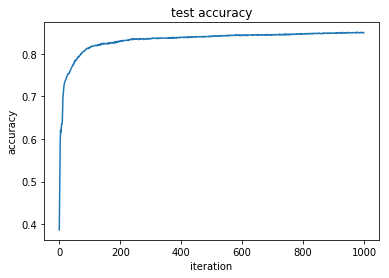

In [9]:
#read train data
trainX, trainY = load_data(train_data_path)

#read test data
testX, testY = load_data(test_data_path)

print(trainX.shape, trainY.shape)
print(testX.shape, testY.shape)

#create train and predict function
train, predict = create_3_layer_NN(decay, learning_rate, n_input, n_hidden, n_output)

# train and test
train_cost, test_accuracy = run_NN_model(train, predict, batch_size, trainX, trainY, testX, testY, epochs)

#Plots
%matplotlib inline
draw_plot(range(epochs), train_cost, 'iteration', 'cross-entropy', 'training cost', figure_dir_path, 'pa1_cost.png')
draw_plot(range(epochs), test_accuracy, 'iteration', 'accuracy', 'test accuracy', figure_dir_path, 'pa1_accuracy.png')


2.Find the optimal batch size for mini-batch gradient descent while training the neural
network by evaluating the performances for different batch sizes. Set this as the batch
size for the rest of the experiments.<br/>
a. Plot the training errors and test accuracies against the number of epochs for the 3-layer network for different batch sizes. Limit search space to:{4,8,16,32,64}.<br/>
b. Plot the time taken to update parameters of the network against different batch
sizes.

In [10]:
# Question 2
batch_sizes = [4,8,16,32,64]
time_for_update = np.zeros(max(batch_sizes) + 1)
train_cost_all_batch = {}
test_accuracy_all_batch = {}
train_size = len(trainX)

for batch_size in batch_sizes:
    print("Batch size %d"%(batch_size))
    # create model
    train, predict = create_3_layer_NN(decay, learning_rate, n_input, n_hidden, n_output)
    
    # run model
    t = time.time()
    train_cost, test_accuracy = run_NN_model(train, predict, batch_size, trainX, trainY, testX, testY, epochs)

    time_for_update[batch_size] = 1000*(time.time()-t)/(train_size//batch_size)*100/epochs
    train_cost_all_batch[batch_size] = train_cost
    test_accuracy_all_batch[batch_size] = test_accuracy


Batch size 4
Decay: 1e-06
Learning rate: 0.01
Input size: 36
Hidden size: 10
Output size: 6
Batch size: 4
Epoch: 0
Epoch: 100
Epoch: 200
Epoch: 300
Epoch: 400
Epoch: 500
Epoch: 600
Epoch: 700
Epoch: 800
Epoch: 900
89.2 accuracy at 987 iterations
Batch size 8
Decay: 1e-06
Learning rate: 0.01
Input size: 36
Hidden size: 10
Output size: 6
Batch size: 8
Epoch: 0
Epoch: 100
Epoch: 200
Epoch: 300
Epoch: 400
Epoch: 500
Epoch: 600
Epoch: 700
Epoch: 800
Epoch: 900
87.5 accuracy at 967 iterations
Batch size 16
Decay: 1e-06
Learning rate: 0.01
Input size: 36
Hidden size: 10
Output size: 6
Batch size: 16
Epoch: 0
Epoch: 100
Epoch: 200
Epoch: 300
Epoch: 400
Epoch: 500
Epoch: 600
Epoch: 700
Epoch: 800
Epoch: 900
86.0 accuracy at 983 iterations
Batch size 32
Decay: 1e-06
Learning rate: 0.01
Input size: 36
Hidden size: 10
Output size: 6
Batch size: 32
Epoch: 0
Epoch: 100
Epoch: 200
Epoch: 300
Epoch: 400
Epoch: 500
Epoch: 600
Epoch: 700
Epoch: 800
Epoch: 900
84.7 accuracy at 998 iterations
Batch size 6

a. Plot the training errors and test accuracies against the number of epochs for the 3-layer network for different batch sizes. Limit search space to:{4,8,16,32,64}.<br/>
b. Plot the time taken to update parameters of the network against different batch sizes.

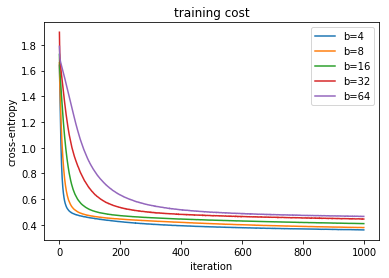

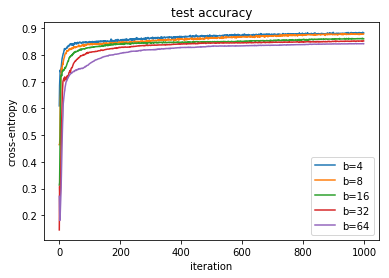

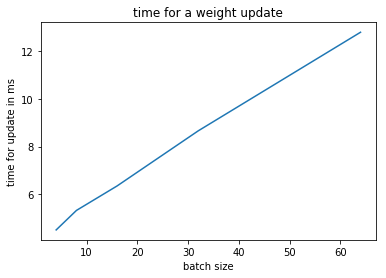

In [19]:
# plots
% matplotlib inline
draw_multi_plot(range(epochs), train_cost_all_batch, 'iteration', 'cross-entropy', batch_sizes, "b=", 'training cost', figure_dir_path, 'pa2_cost.png')
draw_multi_plot(range(epochs), test_accuracy_all_batch, 'iteration', 'cross-entropy', batch_sizes, "b=", 'test accuracy', figure_dir_path, 'pa2_accuracy.png')
draw_plot(batch_sizes, time_for_update[batch_sizes], 'batch size', 'time for update in ms', 'time for a weight update', figure_dir_path, 'pa2_time_update.png')


c. State the rationale for selecting the optimal batch size. 

From the ploting, smaller batch size means the plot line of accuracy and loss tend to unstable/noisy. However, smaller batch size exploit more randomness in dataset that lead to achieve more accuracy and less cost.<br/>
In terms of time, update weight time is faster whan train a smaller batch of data in one iteration since the training data matrix is smaller. However, smaller batch size also means longer training time in one iteration since all batches of data need to be trained in one iteration and training a batch of data have some overhead time.<br/>
In other word, choosing between smaller or larger batch size have their own disadvantage. Our consideration is to balance the advantage and disadvantage when choosing batch size. So, we choose 16 as it is in middle of the batch size range.

In [20]:
batch_size = 16
hidden_sizes = [5, 10, 15, 20, 25]
time_for_update = np.zeros(max(hidden_sizes) + 1)
train_cost_all_hidden = {}
test_accuracy_all_hidden = {}
train_size = len(trainX)

for n_hidden in hidden_sizes:
    # create model
    train, predict = create_3_layer_NN(decay, learning_rate, n_input, n_hidden, n_output)
    
    # run model
    t = time.time()
    train_cost, test_accuracy = run_NN_model(train, predict, batch_size, trainX, trainY, testX, testY, epochs)

    time_for_update[n_hidden] = 1000*(time.time()-t)/epochs
    train_cost_all_hidden[n_hidden] = train_cost
    test_accuracy_all_hidden[n_hidden] = test_accuracy

    

Decay: 1e-06
Learning rate: 0.01
Input size: 36
Hidden size: 5
Output size: 6
Batch size: 16
Epoch: 0
Epoch: 100
Epoch: 200
Epoch: 300
Epoch: 400
Epoch: 500
Epoch: 600
Epoch: 700
Epoch: 800
Epoch: 900
85.8 accuracy at 983 iterations
Decay: 1e-06
Learning rate: 0.01
Input size: 36
Hidden size: 10
Output size: 6
Batch size: 16
Epoch: 0
Epoch: 100
Epoch: 200
Epoch: 300
Epoch: 400
Epoch: 500
Epoch: 600
Epoch: 700
Epoch: 800
Epoch: 900
86.1 accuracy at 962 iterations
Decay: 1e-06
Learning rate: 0.01
Input size: 36
Hidden size: 15
Output size: 6
Batch size: 16
Epoch: 0
Epoch: 100
Epoch: 200
Epoch: 300
Epoch: 400
Epoch: 500
Epoch: 600
Epoch: 700
Epoch: 800
Epoch: 900
86.4 accuracy at 992 iterations
Decay: 1e-06
Learning rate: 0.01
Input size: 36
Hidden size: 20
Output size: 6
Batch size: 16
Epoch: 0
Epoch: 100
Epoch: 200
Epoch: 300
Epoch: 400
Epoch: 500
Epoch: 600
Epoch: 700
Epoch: 800
Epoch: 900
85.8 accuracy at 983 iterations
Decay: 1e-06
Learning rate: 0.01
Input size: 36
Hidden size: 25
O

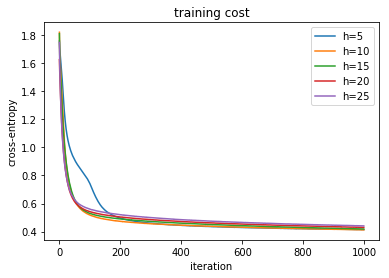

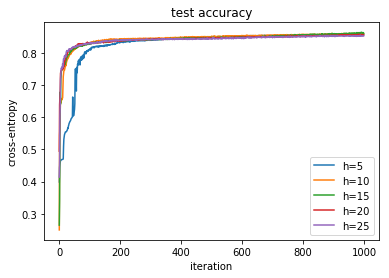

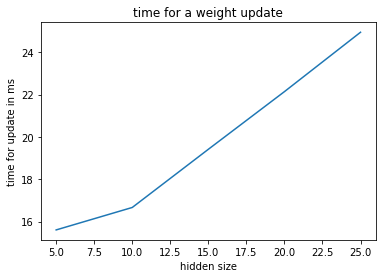

In [21]:
# plots
% matplotlib inline
draw_multi_plot(range(epochs), train_cost_all_hidden, 'iteration', 'cross-entropy', hidden_sizes, "h=", 'training cost', figure_dir_path, 'pa3_cost.png')
draw_multi_plot(range(epochs), test_accuracy_all_hidden, 'iteration', 'cross-entropy', hidden_sizes, "h=", 'test accuracy', figure_dir_path, 'pa3_accuracy.png')
draw_plot(hidden_sizes, time_for_update[hidden_sizes], 'hidden size', 'time for update in ms', 'time for a weight update', figure_dir_path, 'pa3_time_update.png')


In case of small hidden layer size, the accuracy is smaller than the larger hidden layer size. However, the accuracy is higher than the larger hidden layer size with enough epochs. It is also same as the cost plot. The cost is higher when using small hidden layer. However with enough epochs, the cost is lower. It happends because more hidden layer size means more number of weight, so it need more epochs to train the weights.<br/>
The time for weight update is also proportional with the hidden layer size since higher hidden layer size means more number of weight. To balance the advantage and disadvantage, we choose 15.

In [23]:
list_decay = [1e-3, 1e-6, 1e-9, 1e-12, 0]
n_hidden = 15
batch_size = 16
train_cost_all_decay = {}
test_accuracy_all_decay = {}
train_size = len(trainX)
epochs = 2000

for decay in list_decay:
    # create model
    train, predict = create_3_layer_NN(decay, learning_rate, n_input, n_hidden, n_output)
    
    # run model
    t = time.time()
    train_cost, test_accuracy = run_NN_model(train, predict, batch_size, trainX, trainY, testX, testY, epochs)

    train_cost_all_decay[decay] = train_cost
    test_accuracy_all_decay[decay] = test_accuracy

Decay: 0.001
Learning rate: 0.01
Input size: 36
Hidden size: 15
Output size: 6
Batch size: 16
Epoch: 0
Epoch: 100
Epoch: 200
Epoch: 300
Epoch: 400
Epoch: 500
Epoch: 600
Epoch: 700
Epoch: 800
Epoch: 900
Epoch: 1000
Epoch: 1100
Epoch: 1200
Epoch: 1300
Epoch: 1400
Epoch: 1500
Epoch: 1600
Epoch: 1700
Epoch: 1800
Epoch: 1900
63.8 accuracy at 43 iterations
Decay: 1e-06
Learning rate: 0.01
Input size: 36
Hidden size: 15
Output size: 6
Batch size: 16
Epoch: 0
Epoch: 100
Epoch: 200
Epoch: 300
Epoch: 400
Epoch: 500
Epoch: 600
Epoch: 700
Epoch: 800
Epoch: 900
Epoch: 1000
Epoch: 1100
Epoch: 1200
Epoch: 1300
Epoch: 1400
Epoch: 1500
Epoch: 1600
Epoch: 1700
Epoch: 1800
Epoch: 1900
87.8 accuracy at 1928 iterations
Decay: 1e-09
Learning rate: 0.01
Input size: 36
Hidden size: 15
Output size: 6
Batch size: 16
Epoch: 0
Epoch: 100
Epoch: 200
Epoch: 300
Epoch: 400
Epoch: 500
Epoch: 600
Epoch: 700
Epoch: 800
Epoch: 900
Epoch: 1000
Epoch: 1100
Epoch: 1200
Epoch: 1300
Epoch: 1400
Epoch: 1500
Epoch: 1600
Epoch:

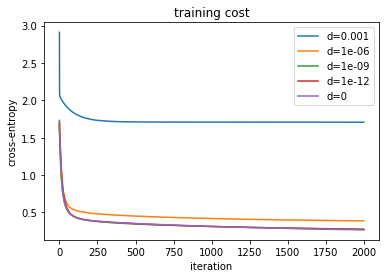

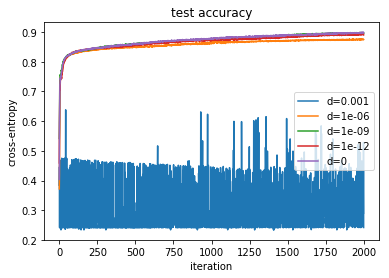

In [24]:
# plots
% matplotlib inline
draw_multi_plot(range(epochs), train_cost_all_decay, 'iteration', 'cross-entropy', list_decay, "d=", 'training cost', figure_dir_path, 'pa4_cost.png')
draw_multi_plot(range(epochs), test_accuracy_all_decay, 'iteration', 'cross-entropy', list_decay, "d=", 'test accuracy', figure_dir_path, 'pa4_accuracy.png')


In [35]:
def create_4_layer_NN(decay, learning_rate, n_input, n_hidden1, n_hidden2, n_output):
    #debug
    print("Decay: " + str(decay))
    print("Learning rate: " + str(learning_rate))
    print("Input size: %d"%n_input)
    print("Hidden1 size: %d"%n_hidden1)
    print("Hidden2 size: %d"%n_hidden2)
    print("Output size: %d"%n_output)
    
    # theano expressions
    X = T.matrix() #features
    Y = T.matrix() #output

    w1, b1 = init_weights(n_input, n_hidden1), init_bias(n_hidden1) #weights and biases from input to hidden layer
    w2, b2 = init_weights(n_hidden1, n_hidden2), init_bias(n_hidden2) #weights and biases from hidden 1 to hidden 2 layer
    w3, b3 = init_weights(n_hidden2, n_output, logistic=False), init_bias(n_output) #weights and biases from hidden 2 to output layer

    # connect layer
    h1 = T.nnet.sigmoid(T.dot(X, w1) + b1)
    h2 = T.nnet.sigmoid(T.dot(h1, w2) + b2)
    py = T.nnet.softmax(T.dot(h2, w3) + b3)

    # decode to category number
    y_x = T.argmax(py, axis=1)

    cost = T.mean(T.nnet.categorical_crossentropy(py, Y)) + decay*(T.sum(T.sqr(w1)+T.sum(T.sqr(w2) + T.sum(T.sqr(w3)))))
    sw1 = T.sqr(w1)
    sw2 = T.sqr(w2)
    sum1 = sw1
    sum2 = T.sum(sum1)
    sum3 = sw1+10
    params = [w1, b1, w2, b2, w3, b3]
    updates = sgd(cost, params, learning_rate)

    # compile
    train = theano.function(inputs=[X, Y], outputs=cost, updates=updates, allow_input_downcast=True)
    predict = theano.function(inputs=[X], outputs=[y_x, sum1, sum2, sum3], allow_input_downcast=True)

    return train, predict

Decay: 1e-06
Learning rate: 0.01
Input size: 36
Hidden1 size: 10
Hidden2 size: 10
Output size: 6
Batch size: 64
Epoch: 0
Epoch: 100
Epoch: 200
Epoch: 300
Epoch: 400
Epoch: 500
Epoch: 600
Epoch: 700
Epoch: 800
Epoch: 900
74.0 accuracy at 988 iterations
[[  3.57783677e-01   8.26740062e-02   1.95698492e+00   1.27839100e+00
    1.49636788e+00   1.44089908e-03   3.26971928e-01   2.67194593e-02
    6.07574574e-01   4.29233793e+00]
 [  1.49510884e+00   3.65972059e-01   1.47626667e+00   3.46193904e+00
    2.75472287e-01   2.38653021e+00   3.70237052e+00   2.57756923e+00
    3.44781577e-01   1.73659270e+00]
 [  2.77313588e+00   3.34444162e-01   5.87595290e-02   6.76010136e-04
    1.23625570e+00   1.56746490e-01   6.60334469e-02   8.99883187e-01
    1.16756810e-01   7.83974940e-01]
 [  5.80686488e-01   8.88106533e-01   2.41355836e-01   7.07024691e-01
    1.10865975e-02   6.87449284e-03   3.00795802e-01   1.09666422e-01
    6.31040523e-02   1.00435430e+00]
 [  2.97521161e+00   4.02910736e-01   7.

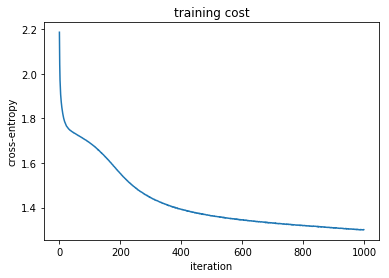

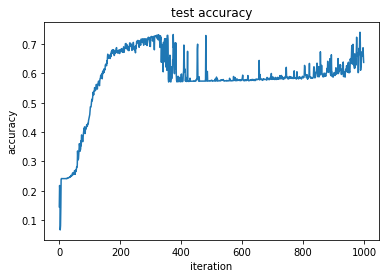

In [36]:
def run_NN_model2(train, predict, batch_size, trainX, trainY, testX, testY, epochs):
    #debug
    print("Batch size: %d"%batch_size)
    # train and test
    n = len(trainX)
    test_accuracy = []
    train_cost = []
    sum1 = 0
    sw1 = 0
    sw2 = 0
    for i in range(epochs):
        if i%100 == 0:
            print("Epoch: %d"%i)
        
        trainX, trainY = shuffle_data(trainX, trainY)
        cost = 0.0
        for start, end in zip(range(0, n, batch_size), range(batch_size, n, batch_size)):
            cost += train(trainX[start:end], trainY[start:end])
        train_cost = np.append(train_cost, cost/(n // batch_size))
        res, sum1, sw1, sw2= predict(testX)
        test_accuracy = np.append(test_accuracy, np.mean(np.argmax(testY, axis=1) == res))

    print('%.1f accuracy at %d iterations'%(np.max(test_accuracy)*100, np.argmax(test_accuracy)+1))
    print(sum1)
    print(sw1)
    print(sw2)
    return train_cost, test_accuracy


n_hidden1 = 10
n_hidden2 = 10
batch_size = 64
decay = 1e-6
epochs = 1000

#create train and predict function
train, predict = create_4_layer_NN(decay, learning_rate, n_input, n_hidden1, n_hidden2, n_output)

# train and test
train_cost, test_accuracy = run_NN_model2(train, predict, batch_size, trainX, trainY, testX, testY, epochs)

#Plots
%matplotlib inline
draw_plot(range(epochs), train_cost, 'iteration', 'cross-entropy', 'training cost', figure_dir_path, 'pa5_cost.png')
draw_plot(range(epochs), test_accuracy, 'iteration', 'accuracy', 'test accuracy', figure_dir_path, 'pa5_accuracy.png')


